## Clean Hotel Data

In [67]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pylab as pl

#Import data
hotels = pd.read_csv('hotel_data.csv')
activity = pd.read_csv('activity_data.csv')

#Clean data to get rid of NaN and categorical variables through ones hot encoding
#df.loc[df['city_name'] == 'Brookyln']
df = hotels.loc[hotels['city_name'] == 'Brooklyn']
df = pd.get_dummies(data=hotels, columns=['hotel_type','parent_brand_name'])
df.dropna(inplace = True)
df.drop(['hotel_id','hotel_name','brand_name','city_name'],axis = 1,inplace = True)

#Scale values from 0 to 1
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

## Create Primary Clustering

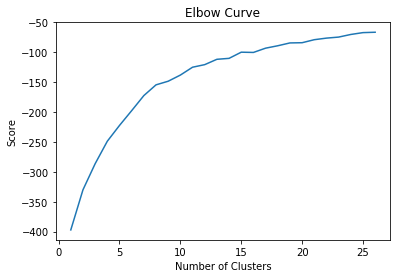

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 402 samples in 0.001s...
[t-SNE] Computed neighbors for 402 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 402 / 402
[t-SNE] Mean sigma: 0.287255
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.266392
[t-SNE] KL divergence after 1000 iterations: 0.140290


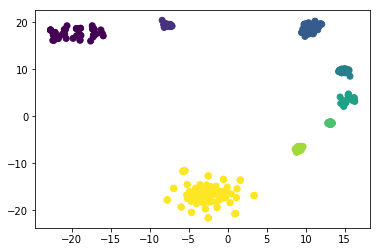

In [68]:
#Cluster the data
clmns = list(df)
Nc = range(1, 27)
kmeans = [KMeans(n_clusters=i, random_state=0, max_iter = 1000) for i in Nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]

#Plot Elbow Curve
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#Run KMeans
clmns = list(df)
kmeans = KMeans(n_clusters = 8, random_state = 2)
kmeans.fit(df)
labels = kmeans.labels_

#Find centers
centers = np.array(kmeans.cluster_centers_)

#Glue back to original data
df['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
df.groupby(['clusters']).mean()

#run the clusters on a T sne 
tsne = TSNE(n_components = 2, verbose = 1 , perplexity = 40, n_iter=1000)
output = tsne.fit_transform(df.loc[:])

#visualize clusters
list1 = [i[0] for i in output]
list2 = [i[1] for i in output]
plt.scatter(list1,list2, c = labels)

#export clusters
pd.DataFrame(centers).to_csv(r'centers.csv')

## Calculate 'Hotel-Cross Over'

In [66]:
# delete hotel values that are less common (we won't be recommending them)
threshold = 2000
value_counts = activity['hotel_id'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index

activity_clean = activity['hotel_id'].replace(to_remove, np.nan).dropna()

array = activity_clean['user_id'].unique()
n = len(array);
h = len(activity_clean['hotel_id'].unique())

matrix = np.zeros((h,n)); 
df = pd.DataFrame(matrix, columns = array)

df.index = activity_clean['hotel_id'].unique()

# create matrix with people and what hotels they viewed

for hotel_id in activity_clean['hotel_id'].unique():
    data = activity_clean.loc[activity_clean['hotel_id'] == hotel_id]['user_id'].values
    for i in range(len(data)):
        df.loc[hotel_id, data[i]] = 1

df = df.transpose()

# export matrix with people as index and hotels they viewed as column

df.to_pickle('./person_data.csv')

# then tack on this dataframe to our original data

result_by_person = pd.merge(activity, df, left_on = 'user_id', right_index = True, how = 'left')

# then tack on this dataframe to our original data

hotel_groupings = result_by_person.dropna().drop(['user_id', 'user_country', 'device', 'user_action'], axis=1)

# then group by mean -- we can see what hotels people are likely to go to after viewing one hotel
# obviously this will have a 1 in the column where we have the same hotel
# data looks very good overall -- some very high correlations, I saw a couple .2's

final_hotel_data = hotel_groupings.groupby(['hotel_id']).mean()

final_hotel_data.to_pickle('./hotels.pkl')

IndexError: user_id

## Final Clustering using 'Hotel Cross-Over'

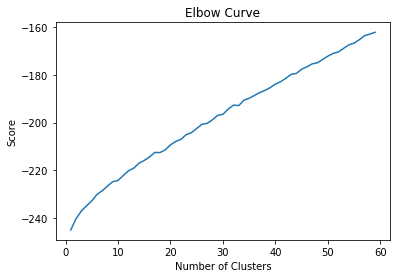

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.000s...
[t-SNE] Computed neighbors for 240 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 0.315365
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.815807
[t-SNE] KL divergence after 1000 iterations: 0.293307


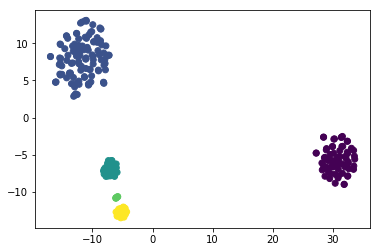

In [71]:
df = pd.read_csv('hotel_comparison_data.csv')
df.drop(['hotel_id'],axis = 1, inplace = True)

#Cluster the data
clmns = list(df)
Nc = range(1, 60)
kmeans = [KMeans(n_clusters=i, random_state=0, max_iter = 1000) for i in Nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]

#Plot Elbow Curve
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#Run KMeans
clmns = list(df)
kmeans = KMeans(n_clusters = 5, random_state = 2)
kmeans.fit(df)
labels = kmeans.labels_

#Find centers
centers = np.array(kmeans.cluster_centers_)

#Glue back to original data
df['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
df.groupby(['clusters']).mean()

#run the clusters on a T sne 
tsne = TSNE(n_components = 2, verbose = 1 , perplexity = 40, n_iter=1000)
output = tsne.fit_transform(df.loc[:])

#visualize clusters
list1 = [i[0] for i in output]
list2 = [i[1] for i in output]
plt.scatter(list1,list2, c = labels)

## Create 'Top 5' Recommender System

In [ ]:
import pandas as pd
from scipy.spatial import distance
df = pd.read_pickle('hotels.pkl')

array = df.values.tolist()

distanceslist = []
rowlist = []
for v1 in array:
    for v2 in array:
        rowlist.append(distance.cityblock(v1, v2))   
    distanceslist.append(rowlist)
    rowlist = []


suggestlist = []
suggestlistrow = []
i = 0
while i < len(distanceslist):
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    distanceslist[i][minIndex] = 99
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    distanceslist[i][minIndex] = 99
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    distanceslist[i][minIndex] = 99
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    distanceslist[i][minIndex] = 99
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    distanceslist[i][minIndex] = 99
    minIndex = distanceslist[i].index(min(distanceslist[i]))
    suggestlistrow.append(minIndex)
    suggestlistrow.append(minIndex)
    suggestlist.append(suggestlistrow)
    suggestlistrow = []
    i = i + 1

import numpy as np
np.savetxt("final_results.csv", suggestlist, delimiter=",", fmt='%s')